## Importando Bibliotecas

In [57]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Adquirindo e Consolidando os Dados

In [58]:
### PEGANDO OS ARQUIVOS DO GITHUB

api_url = f"https://api.github.com/repos/RatonesR/pos_graduacao_maua/contents/analise_estatistica_dados/atividade_final"

response = requests.get(api_url)
lista_de_arquivos = []

conteudo = response.json()
for item in conteudo:
    match = re.match(r"microdados_censo_escolar_(\d{4})\.zip", item['name'])
    if item['type'] == 'file' and match:
        ano = match.group(1)
        url_download = item['download_url']
        nome_arquivo = item['name']
        lista_de_arquivos.append({'ano': ano, 'nome': nome_arquivo, 'url': url_download})
print(f"Arquivos encontrados: {[f['nome'] for f in lista_de_arquivos]}")

Arquivos encontrados: ['microdados_censo_escolar_2022.zip', 'microdados_censo_escolar_2023.zip', 'microdados_censo_escolar_2024.zip']


In [59]:
### COLUNAS DE INTERESSE

colunas_de_interesse = [
    # --- Identificação e Localização ---
    'NU_ANO_CENSO',
    'NO_REGIAO',
    'SG_UF',
    'NO_MUNICIPIO',
    'TP_DEPENDENCIA',
    'TP_LOCALIZACAO',
    # --- Infraestrutura Básica ---
    'IN_AGUA_POTAVEL',
    'IN_AGUA_REDE_PUBLICA',
    'IN_ENERGIA_REDE_PUBLICA',
    'IN_ESGOTO_REDE_PUBLICA',
    'IN_LIXO_SERVICO_COLETA',
    'IN_TRATAMENTO_LIXO_RECICLAGEM',
    # --- Dependências Físicas ---
    'IN_BIBLIOTECA',
    'IN_LABORATORIO_CIENCIAS',
    'IN_LABORATORIO_INFORMATICA',
    'IN_QUADRA_ESPORTES',
    'IN_COZINHA',
    'IN_BANHEIRO',
    'IN_REFEITORIO',
    'IN_SALA_LEITURA',
    'IN_SALA_PROFESSOR',
    # --- Equipamentos e Tecnologia ---
    'IN_COMPUTADOR',
    'IN_INTERNET',
    'IN_BANDA_LARGA',
    # --- Quantitativos ---
    'QT_SALAS_UTILIZADAS',
    'QT_DOC_BAS',
    'QT_MAT_BAS'
]

In [60]:
### TRANSFORMA OS DADOS EM DATAFRAMES

lista_dataframes = []

for arquivo in lista_de_arquivos:
    ano = arquivo['ano']
    nome_arquivo_zip = arquivo['nome']
    url_zip = arquivo['url']
    caminho_zip = nome_arquivo_zip

    print(f"Baixando {nome_arquivo_zip}...")
    response_download = requests.get(url_zip, stream=True)
    with open(caminho_zip, 'wb') as f:
        f.write(response_download.content)

    caminho_extracao = f"dados_{ano}"
    with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
        zip_ref.extractall(caminho_extracao)

    caminho_csv = None
    for root, dirs, files in os.walk(caminho_extracao):
        for file in files:
            if file.lower().startswith('microdados_ed_basica_') and file.lower().endswith('.csv'):
                caminho_csv = os.path.join(root, file)
                break
    df_ano = pd.read_csv(
        caminho_csv,
        sep=';',
        encoding='latin-1',
        low_memory=False,
        usecols=colunas_de_interesse
    )

    lista_dataframes.append(df_ano)
print("Concluído!")

Baixando microdados_censo_escolar_2022.zip...
Baixando microdados_censo_escolar_2023.zip...
Baixando microdados_censo_escolar_2024.zip...
Concluído!


In [61]:
for i in lista_dataframes:
    lista = i.columns.tolist()
    print(lista)
    print(f"Número de colunas do dataframe: {len(lista)}")

['NU_ANO_CENSO', 'NO_REGIAO', 'SG_UF', 'NO_MUNICIPIO', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO', 'IN_AGUA_POTAVEL', 'IN_AGUA_REDE_PUBLICA', 'IN_ENERGIA_REDE_PUBLICA', 'IN_ESGOTO_REDE_PUBLICA', 'IN_LIXO_SERVICO_COLETA', 'IN_TRATAMENTO_LIXO_RECICLAGEM', 'IN_BANHEIRO', 'IN_BIBLIOTECA', 'IN_COZINHA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_QUADRA_ESPORTES', 'IN_REFEITORIO', 'IN_SALA_LEITURA', 'IN_SALA_PROFESSOR', 'QT_SALAS_UTILIZADAS', 'IN_COMPUTADOR', 'IN_INTERNET', 'IN_BANDA_LARGA', 'QT_MAT_BAS', 'QT_DOC_BAS']
Número de colunas do dataframe: 27
['NU_ANO_CENSO', 'NO_REGIAO', 'SG_UF', 'NO_MUNICIPIO', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO', 'IN_AGUA_POTAVEL', 'IN_AGUA_REDE_PUBLICA', 'IN_ENERGIA_REDE_PUBLICA', 'IN_ESGOTO_REDE_PUBLICA', 'IN_LIXO_SERVICO_COLETA', 'IN_TRATAMENTO_LIXO_RECICLAGEM', 'IN_BANHEIRO', 'IN_BIBLIOTECA', 'IN_COZINHA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_QUADRA_ESPORTES', 'IN_REFEITORIO', 'IN_SALA_LEITURA', 'IN_SALA_PROFESSOR', 'QT_SALA

In [62]:
### CONSOLIDANDO DATAFRAME E VERIFICANDO DADOS

df_consolidado = pd.concat(lista_dataframes, ignore_index=True)
df_consolidado.info()
print()
print(f"Quantidade de dados por ano:\n{df_consolidado['NU_ANO_CENSO'].value_counts().sort_index()}")
print()
print("Dataframe Consolidado:")
display(df_consolidado.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657819 entries, 0 to 657818
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   NU_ANO_CENSO                   657819 non-null  int64  
 1   NO_REGIAO                      657819 non-null  object 
 2   SG_UF                          657819 non-null  object 
 3   NO_MUNICIPIO                   657819 non-null  object 
 4   TP_DEPENDENCIA                 657819 non-null  int64  
 5   TP_LOCALIZACAO                 657819 non-null  int64  
 6   IN_AGUA_POTAVEL                541368 non-null  float64
 7   IN_AGUA_REDE_PUBLICA           541368 non-null  float64
 8   IN_ENERGIA_REDE_PUBLICA        541368 non-null  float64
 9   IN_ESGOTO_REDE_PUBLICA         541368 non-null  float64
 10  IN_LIXO_SERVICO_COLETA         541368 non-null  float64
 11  IN_TRATAMENTO_LIXO_RECICLAGEM  541368 non-null  float64
 12  IN_BANHEIRO                   

,NU_ANO_CENSO,NO_REGIAO,SG_UF,NO_MUNICIPIO,TP_DEPENDENCIA,TP_LOCALIZACAO,IN_AGUA_POTAVEL,IN_AGUA_REDE_PUBLICA,IN_ENERGIA_REDE_PUBLICA,IN_ESGOTO_REDE_PUBLICA,...,IN_QUADRA_ESPORTES,IN_REFEITORIO,IN_SALA_LEITURA,IN_SALA_PROFESSOR,QT_SALAS_UTILIZADAS,IN_COMPUTADOR,IN_INTERNET,IN_BANDA_LARGA,QT_MAT_BAS,QT_DOC_BAS
0,2022,Norte,RO,Alta Floresta D'Oeste,2,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,6.0,1.0
1,2022,Norte,RO,Alta Floresta D'Oeste,2,1,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,200.0,15.0
2,2022,Norte,RO,Alta Floresta D'Oeste,3,2,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,9.0,1.0
3,2022,Norte,RO,Alta Floresta D'Oeste,3,1,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,9.0,1.0,1.0,0.0,118.0,8.0
4,2022,Norte,RO,Alta Floresta D'Oeste,3,2,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,7.0,0.0,1.0,0.0,161.0,20.0


## Limpeza dos Dados

In [63]:
df_consolidado.head()

,NU_ANO_CENSO,NO_REGIAO,SG_UF,NO_MUNICIPIO,TP_DEPENDENCIA,TP_LOCALIZACAO,IN_AGUA_POTAVEL,IN_AGUA_REDE_PUBLICA,IN_ENERGIA_REDE_PUBLICA,IN_ESGOTO_REDE_PUBLICA,...,IN_QUADRA_ESPORTES,IN_REFEITORIO,IN_SALA_LEITURA,IN_SALA_PROFESSOR,QT_SALAS_UTILIZADAS,IN_COMPUTADOR,IN_INTERNET,IN_BANDA_LARGA,QT_MAT_BAS,QT_DOC_BAS
0,2022,Norte,RO,Alta Floresta D'Oeste,2,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,6.0,1.0
1,2022,Norte,RO,Alta Floresta D'Oeste,2,1,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,200.0,15.0
2,2022,Norte,RO,Alta Floresta D'Oeste,3,2,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,9.0,1.0
3,2022,Norte,RO,Alta Floresta D'Oeste,3,1,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,9.0,1.0,1.0,0.0,118.0,8.0
4,2022,Norte,RO,Alta Floresta D'Oeste,3,2,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,7.0,0.0,1.0,0.0,161.0,20.0


In [64]:
df_consolidado.shape

(657819, 27)

In [65]:
df_consolidado.isnull().sum()

,0
NU_ANO_CENSO,0
NO_REGIAO,0
SG_UF,0
NO_MUNICIPIO,0
TP_DEPENDENCIA,0
TP_LOCALIZACAO,0
IN_AGUA_POTAVEL,116451
IN_AGUA_REDE_PUBLICA,116451
IN_ENERGIA_REDE_PUBLICA,116451
IN_ESGOTO_REDE_PUBLICA,116451


In [66]:
colunas_com_nulos = df_consolidado.columns[df_consolidado.isnull().sum() == 116451].tolist()
contagem_nulos_por_linha = df_consolidado[colunas_com_nulos].isnull().sum(axis=1)
print("Número de linhas em que todas as colunas são null:")
print(contagem_nulos_por_linha.value_counts())

Número de linhas em que todas as colunas são null:
0     541368
18    116451
Name: count, dtype: int64


In [67]:
teste = df_consolidado.dropna(subset=colunas_com_nulos, how='all')

In [68]:
teste = df_consolidado[contagem_nulos_por_linha == 0].copy()

In [69]:
display(teste.isnull().sum())
display(teste.shape)

,0
NU_ANO_CENSO,0
NO_REGIAO,0
SG_UF,0
NO_MUNICIPIO,0
TP_DEPENDENCIA,0
TP_LOCALIZACAO,0
IN_AGUA_POTAVEL,0
IN_AGUA_REDE_PUBLICA,0
IN_ENERGIA_REDE_PUBLICA,0
IN_ESGOTO_REDE_PUBLICA,0


(541368, 27)

In [70]:
teste['IN_BANDA_LARGA'] = teste['IN_BANDA_LARGA'].fillna(0)
teste['IN_BANDA_LARGA'].head()

,IN_BANDA_LARGA
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


In [71]:
media_MAT_UF = teste.groupby('SG_UF')['QT_MAT_BAS'].transform("mean")
media_DOC_UF = teste.groupby('SG_UF')['QT_DOC_BAS'].transform("mean")

In [72]:
teste['QT_MAT_BAS'] = teste['QT_MAT_BAS'].fillna(media_MAT_UF)
teste['QT_DOC_BAS'] = teste['QT_DOC_BAS'].fillna(media_DOC_UF)

In [73]:
teste.isnull().sum()

,0
NU_ANO_CENSO,0
NO_REGIAO,0
SG_UF,0
NO_MUNICIPIO,0
TP_DEPENDENCIA,0
TP_LOCALIZACAO,0
IN_AGUA_POTAVEL,0
IN_AGUA_REDE_PUBLICA,0
IN_ENERGIA_REDE_PUBLICA,0
IN_ESGOTO_REDE_PUBLICA,0


In [74]:
colunas_object = teste.select_dtypes(include=['object']).columns
for col in colunas_object:
  teste[col] = teste[col].astype('string')

teste.dtypes

,0
NU_ANO_CENSO,int64
NO_REGIAO,string[python]
SG_UF,string[python]
NO_MUNICIPIO,string[python]
TP_DEPENDENCIA,int64
TP_LOCALIZACAO,int64
IN_AGUA_POTAVEL,float64
IN_AGUA_REDE_PUBLICA,float64
IN_ENERGIA_REDE_PUBLICA,float64
IN_ESGOTO_REDE_PUBLICA,float64


In [75]:
df_limpo = teste.copy()

## Criação de colunas calculadas

In [76]:
mapa_dependencia = {1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'}
df_limpo['TP_DEPENDENCIA_DESC'] = df_limpo['TP_DEPENDENCIA'].map(mapa_dependencia)
df_limpo['TP_DEPENDENCIA_DESC'].value_counts()

,count
TP_DEPENDENCIA_DESC,
Municipal,322812
Privada,127293
Estadual,89149
Federal,2114


In [77]:
mapa_localizacao = {1: 'Urbana', 2: 'Rural'}
df_limpo['TP_LOCALIZACAO_DESC'] = df_limpo['TP_LOCALIZACAO'].map(mapa_localizacao)
df_limpo['TP_LOCALIZACAO_DESC'].value_counts()

,count
TP_LOCALIZACAO_DESC,
Urbana,385383
Rural,155985


In [78]:
df_limpo["PROPORCAO_ALUNO_DOCENTE"] = df_limpo["QT_MAT_BAS"]/df_limpo["QT_DOC_BAS"]
df_limpo["PROPORCAO_ALUNO_DOCENTE"].describe()

,PROPORCAO_ALUNO_DOCENTE
count,541368.000000
mean,15.665089
std,25.928225
min,0.047910
25%,10.000000
50%,14.333333
75%,19.239130
max,10435.000000


In [79]:
df_limpo['DENSIDADE_ALUNO_SALA'] = df_limpo['QT_MAT_BAS'] / df_limpo["QT_SALAS_UTILIZADAS"]
df_limpo['DENSIDADE_ALUNO_SALA'].describe()

,DENSIDADE_ALUNO_SALA
count,541368.000000
mean,28.973853
std,70.969284
min,0.002890
25%,14.666667
50%,24.000000
75%,37.500000
max,36822.000000


In [80]:
colunas_tec = ['IN_LABORATORIO_INFORMATICA', 'IN_INTERNET', 'IN_BANDA_LARGA']
df_limpo['SCORE_TECNOLOGIA'] = df_limpo[colunas_tec].sum(axis=1)
df_limpo['SCORE_TECNOLOGIA'].value_counts()

,count
SCORE_TECNOLOGIA,
2.0,290466
3.0,147331
1.0,52423
0.0,51148


In [81]:
colunas_infra = ['IN_BIBLIOTECA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_QUADRA_ESPORTES', 'IN_INTERNET']
df_limpo['INDICE_INFRA'] = df_limpo[colunas_infra].sum(axis=1)
df_limpo['INDICE_INFRA'].value_counts()

,count
INDICE_INFRA,
1.0,195810
2.0,105970
3.0,91770
4.0,62297
0.0,47229
5.0,38292


In [82]:
cortes = [0,
          df_limpo['QT_MAT_BAS'].quantile(0.25),
          df_limpo['QT_MAT_BAS'].quantile(0.50),
          df_limpo['QT_MAT_BAS'].quantile(0.75),
          df_limpo['QT_MAT_BAS'].max()]
rotulos = ['Pequena', 'Média', 'Grande', 'Extra Grande']
df_limpo['PORTE_ESCOLA'] = pd.cut(df_limpo['QT_MAT_BAS'], bins=cortes, labels=rotulos, include_lowest=True)
df_limpo['PORTE_ESCOLA'].value_counts()

,count
PORTE_ESCOLA,
Pequena,136220
Média,135412
Extra Grande,135229
Grande,134507


In [83]:
df_limpo[['PORTE_ESCOLA', 'QT_MAT_BAS']].groupby('PORTE_ESCOLA').mean()

/tmp/ipython-input-2151058919.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_limpo[['PORTE_ESCOLA', 'QT_MAT_BAS']].groupby('PORTE_ESCOLA').mean()


,QT_MAT_BAS
PORTE_ESCOLA,
Pequena,35.116150
Média,113.798519
Grande,245.327221
Extra Grande,665.842743


In [84]:
df_limpo[['SG_UF', 'NO_MUNICIPIO', 'QT_MAT_BAS', 'QT_DOC_BAS', 'PROPORCAO_ALUNO_DOCENTE', 'DENSIDADE_ALUNO_SALA', 'PORTE_ESCOLA', 'INDICE_INFRA', 'SCORE_TECNOLOGIA']].head()

,SG_UF,NO_MUNICIPIO,QT_MAT_BAS,QT_DOC_BAS,PROPORCAO_ALUNO_DOCENTE,DENSIDADE_ALUNO_SALA,PORTE_ESCOLA,INDICE_INFRA,SCORE_TECNOLOGIA
0,RO,Alta Floresta D'Oeste,6.0,1.0,6.000000,6.000000,Pequena,0.0,0.0
1,RO,Alta Floresta D'Oeste,200.0,15.0,13.333333,25.000000,Grande,5.0,3.0
2,RO,Alta Floresta D'Oeste,9.0,1.0,9.000000,9.000000,Pequena,0.0,0.0
3,RO,Alta Floresta D'Oeste,118.0,8.0,14.750000,13.111111,Média,3.0,1.0
4,RO,Alta Floresta D'Oeste,161.0,20.0,8.050000,23.000000,Média,2.0,1.0


In [85]:
# Removendo Outliers de PROPORCAO_ALUNO_DOCENTE

limite_outlier = df_limpo['PROPORCAO_ALUNO_DOCENTE'].quantile(0.99)

print(f"99% dos dados são de {limite_outlier} alunos por docente")
print(f"Tamanho antes:{df_limpo.shape}")

df_limpo = df_limpo[df_limpo['PROPORCAO_ALUNO_DOCENTE'] <= limite_outlier].copy()

print(f"Tamanho depois: {df_limpo.shape}")

99% dos dados são de 41.0 alunos por docente
Tamanho antes:(541368, 34)
Tamanho depois: (536077, 34)


## Análise exploratória

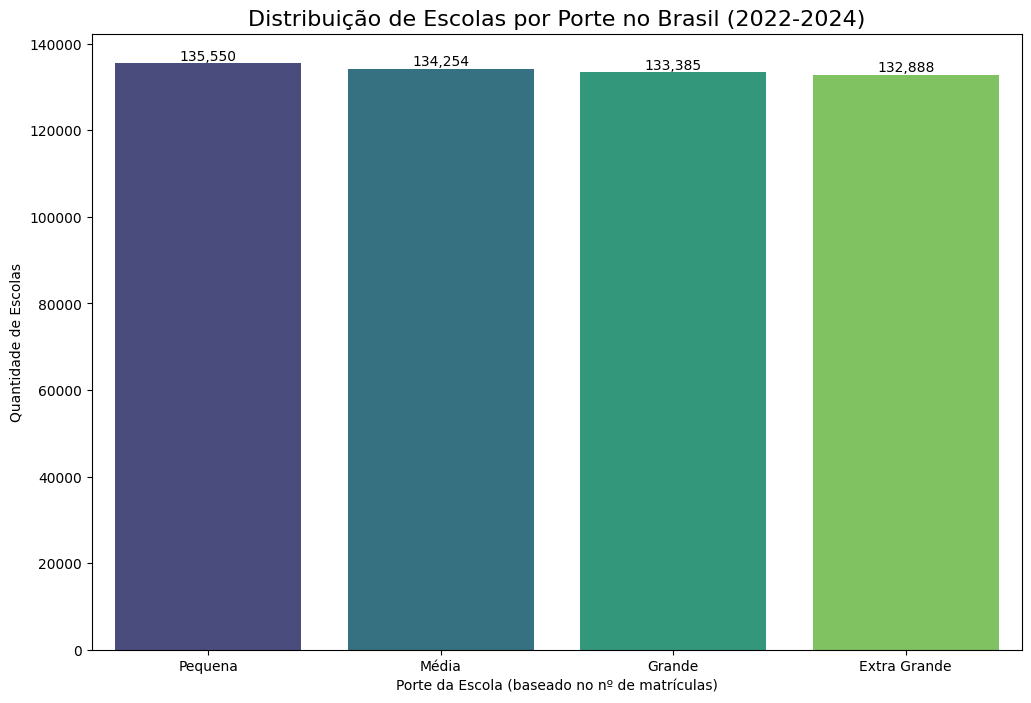


Distribuição equilibrada. Mostra que temos uma base balanceada.


In [86]:
plt.rc('figure', figsize=(12, 8))

ax = sns.countplot(
    data=df_limpo,
    x='PORTE_ESCOLA',
    hue='PORTE_ESCOLA',
    palette='viridis',
    order=['Pequena', 'Média', 'Grande', 'Extra Grande'],
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}'.format)

ax.set_title('Distribuição de Escolas por Porte no Brasil (2022-2024)', fontsize=16)
ax.set_xlabel('Porte da Escola (baseado no nº de matrículas)')
ax.set_ylabel('Quantidade de Escolas')

ax.set_ylim(top=df_limpo['PORTE_ESCOLA'].value_counts().max() * 1.05)

plt.show()

print()
print("Distribuição equilibrada. Mostra que temos uma base balanceada.")

In [87]:
df_limpo["PROPORCAO_ALUNO_DOCENTE"].describe()

,PROPORCAO_ALUNO_DOCENTE
count,536077.000000
mean,15.002687
std,6.788608
min,0.047910
25%,10.000000
50%,14.250000
75%,19.030303
max,41.000000


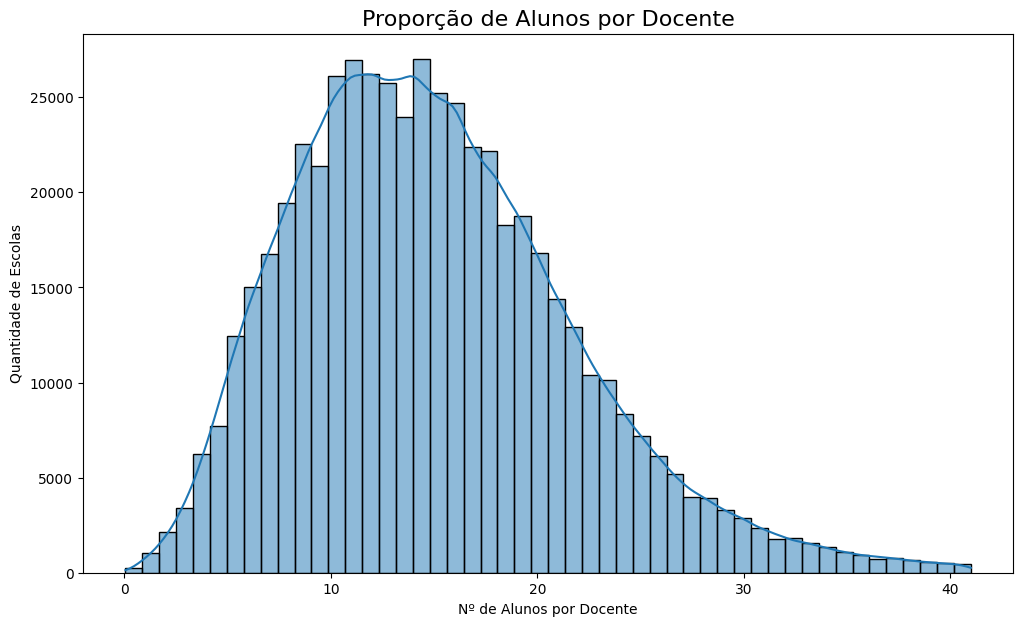


Maioria das escolas opera com um número normal (aceitável) de docentes por aluno. Algumas são um pouco acima da média, com uma proporção mais alta de alunos por docente.


In [88]:
plt.rc('figure', figsize=(12, 7))

sns.histplot(data=df_limpo, x='PROPORCAO_ALUNO_DOCENTE', kde=True, bins=50)

plt.title('Proporção de Alunos por Docente', fontsize=16)
plt.xlabel('Nº de Alunos por Docente')
plt.ylabel('Quantidade de Escolas')

plt.show()

print()
print("Maioria das escolas opera com um número normal (aceitável) de docentes por aluno. Algumas são um pouco acima da média, com uma proporção mais alta de alunos por docente.")

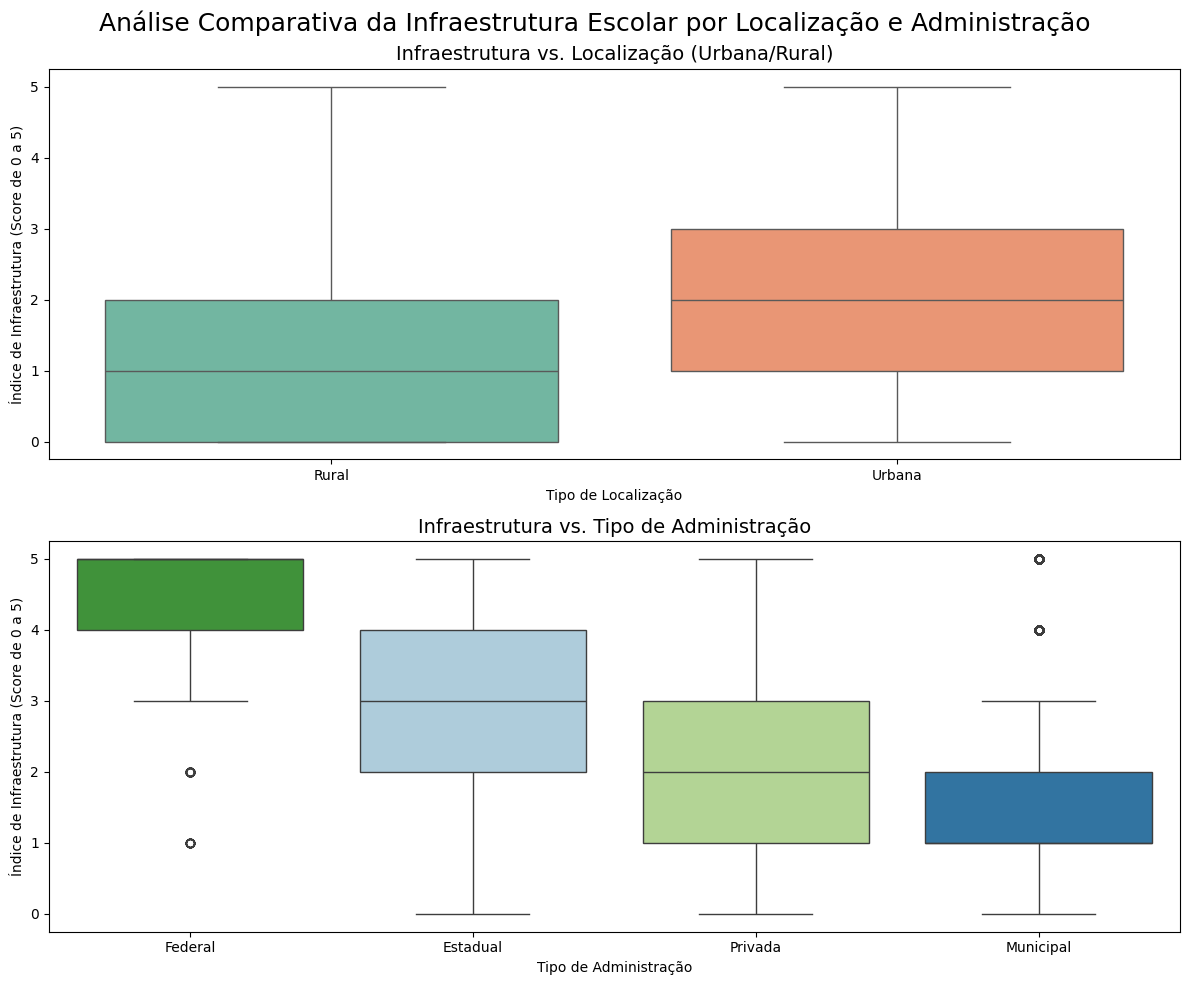


Escolas em áreas urbanas tem mais infraestrutura. Há uma hierarquia entre o tipo de administração nas escolas, com as federais sendo as com melhor infra.


In [89]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
fig.suptitle('Análise Comparativa da Infraestrutura Escolar por Localização e Administração', fontsize=18)


# Primeiro gráfico
sns.boxplot(
    data=df_limpo,
    x='TP_LOCALIZACAO_DESC',
    y='INDICE_INFRA',
    hue='TP_LOCALIZACAO_DESC',
    palette='Set2',
    ax=ax1
)
ax1.set_title('Infraestrutura vs. Localização (Urbana/Rural)', fontsize=14)
ax1.set_xlabel('Tipo de Localização')
ax1.set_ylabel('Índice de Infraestrutura (Score de 0 a 5)')


# Segundo gráfico
sns.boxplot(
    data=df_limpo,
    x='TP_DEPENDENCIA_DESC',
    y='INDICE_INFRA',
    hue='TP_DEPENDENCIA_DESC',
    palette='Paired',
    order=['Federal', 'Estadual', 'Privada', 'Municipal'],
    ax=ax2
)
ax2.set_title('Infraestrutura vs. Tipo de Administração', fontsize=14)
ax2.set_xlabel('Tipo de Administração')
ax2.set_ylabel('Índice de Infraestrutura (Score de 0 a 5)')

# Plot
plt.tight_layout()
plt.show()

print()
print("Escolas em áreas urbanas tem mais infraestrutura. Há uma hierarquia entre o tipo de administração nas escolas, com as federais sendo as com melhor infra.")

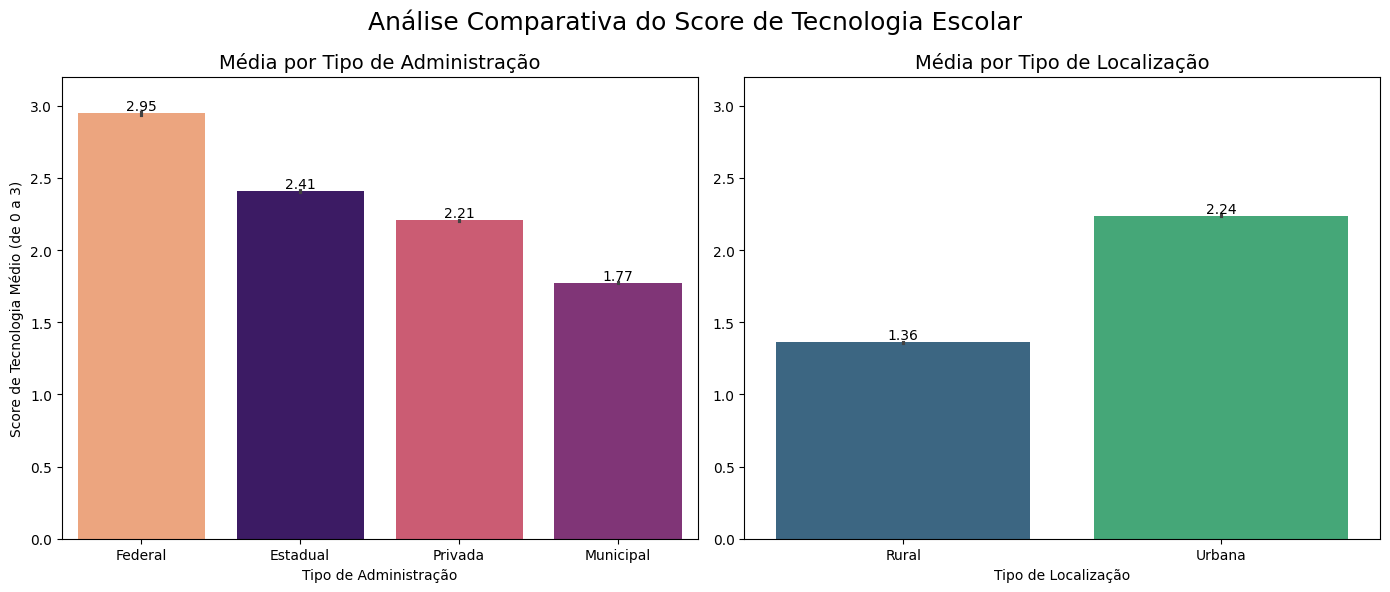


O score de tecnologia por tipo de administração e localização tem o mesmo comportamento da infraestrutura. Podemos criar uma matriz correlação para confirmar o que os gráficos parecem dizer.


In [90]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle('Análise Comparativa do Score de Tecnologia Escolar', fontsize=18)


# Primeiro gráfico
sns.barplot(
    data=df_limpo,
    x='TP_DEPENDENCIA_DESC',
    y='SCORE_TECNOLOGIA',
    hue='TP_DEPENDENCIA_DESC',
    palette='magma',
    order=['Federal', 'Estadual', 'Privada', 'Municipal'],
    ax=ax1
)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f')

ax1.set_title('Média por Tipo de Administração', fontsize=14)
ax1.set_xlabel('Tipo de Administração')
ax1.set_ylabel('Score de Tecnologia Médio (de 0 a 3)')
ax1.set_ylim(top=3.2)


# Segundo gráfico
sns.barplot(
    data=df_limpo,
    x='TP_LOCALIZACAO_DESC',
    y='SCORE_TECNOLOGIA',
    hue='TP_LOCALIZACAO_DESC',
    palette='viridis',
    ax=ax2
)

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f')

ax2.set_title('Média por Tipo de Localização', fontsize=14)
ax2.set_xlabel('Tipo de Localização')
ax2.set_ylabel('')
ax2.set_ylim(top=3.2)

plt.tight_layout()
plt.show()

print()
print("O score de tecnologia por tipo de administração e localização tem o mesmo comportamento da infraestrutura. Podemos criar uma matriz correlação para confirmar o que os gráficos parecem dizer.")

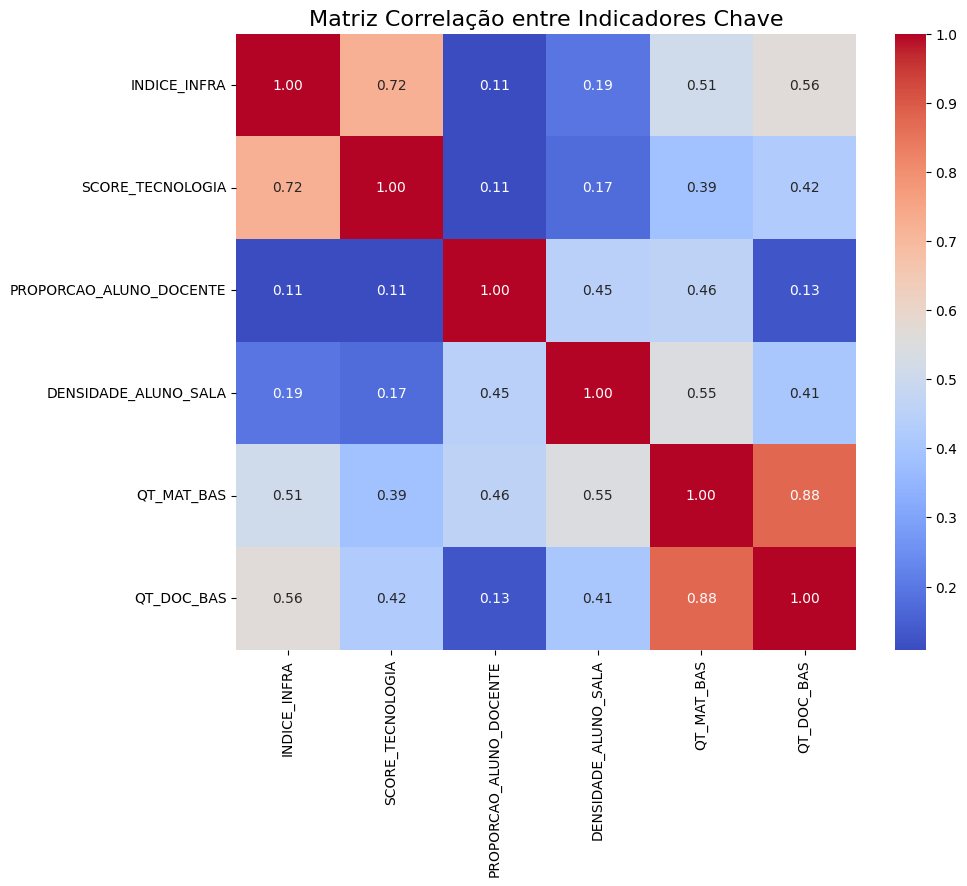


Vemos que há relação entre score de tecnologia e índice de infraestrutura.
Também há forte relação entre quantidade de alunos e de docentes.
Ainda podemos ver certa correlação entre número de alunos e docentes com índice de infraestrutura e de tecnologia.
Também há certa correlação entre quantidade de alunos e docentes por densidade de alunos por sala.


In [91]:
colunas_para_correlacao = [
    'INDICE_INFRA',
    'SCORE_TECNOLOGIA',
    'PROPORCAO_ALUNO_DOCENTE',
    'DENSIDADE_ALUNO_SALA',
    'QT_MAT_BAS',
    'QT_DOC_BAS'
]
correlation_matrix = df_limpo[colunas_para_correlacao].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
)

plt.title('Matriz Correlação entre Indicadores Chave', fontsize=16)
plt.show()

print()
print("Vemos que há relação entre score de tecnologia e índice de infraestrutura.\nTambém há forte relação entre quantidade de alunos e de docentes.\nAinda podemos ver certa correlação entre número de alunos e docentes com índice de infraestrutura e de tecnologia.\nTambém há certa correlação entre quantidade de alunos e docentes por densidade de alunos por sala.")

## Teste de Hipóteses

O índice de infraestrutura é realmente diferente entre escolas no meio rural e urbano?

In [92]:
urbano = df_limpo[df_limpo['TP_LOCALIZACAO_DESC'] == 'Urbana']['INDICE_INFRA']
rural = df_limpo[df_limpo['TP_LOCALIZACAO_DESC'] == 'Rural']['INDICE_INFRA']

stat, p_valor = ttest_ind(urbano.dropna(), rural.dropna(), equal_var=False)

print(f"\nEstatística do teste = {stat:.4f}")
print(f"P-valor = {p_valor}")

# Interpretar resultado
alpha = 0.05  # Nível de significância 5%
if p_valor < alpha:
    print("\nConclusão: Rejeita a Hipótese Nula.")
    print("A diferença entre a localização e o índice de infraestrutura é significativa.")
else:
    print("\nConclusão: Não podemos rejeitar a Hipótese Nula.")
    print("A diferença entre a localização e o índice de infraestrutura não é significativa.")


Estatística do teste = 348.5646
P-valor = 0.0

Conclusão: Rejeita a Hipótese Nula.
A diferença entre a localização e o índice de infraestrutura é significativa.


## ANOVA

As médias de índice de infraestrutura são as mesmas para todos os tipos de dependência?

In [93]:
federal = df_limpo[df_limpo['TP_DEPENDENCIA_DESC'] == 'Federal']['INDICE_INFRA']
estadual = df_limpo[df_limpo['TP_DEPENDENCIA_DESC'] == 'Estadual']['INDICE_INFRA']
privada = df_limpo[df_limpo['TP_DEPENDENCIA_DESC'] == 'Privada']['INDICE_INFRA']
municipal = df_limpo[df_limpo['TP_DEPENDENCIA_DESC'] == 'Municipal']['INDICE_INFRA']

# teste ANOVA
stat_anova, p_valor_anova = f_oneway(federal.dropna(), estadual.dropna(), privada.dropna(), municipal.dropna())

print(f"\nEstatística F = {stat_anova:.4f}")
print(f"P-valor = {p_valor_anova}")

# Interpretar resultado
if p_valor_anova < alpha:
    print("\nConclusão: Rejeita a Hipótese Nula.")
    print("A diferença entre a dependência e o índice de infraestrutura é significativa.")
else:
    print("\nConclusão: Não podemos rejeitar a Hipótese Nula.")
    print("A diferença entre a dependência e o índice de infraestrutura não é significativa.")


Estatística F = 48062.5644
P-valor = 0.0

Conclusão: Rejeita a Hipótese Nula.
A diferença entre a dependência e o índice de infraestrutura é significativa.


## Modelo de Regressão

In [94]:
print("Modelo de Regressão Linear")

# Variáveis independentes (preditoras)
features = ['INDICE_INFRA', 'QT_DOC_BAS', 'SCORE_TECNOLOGIA']
X = df_limpo[features]

# Variável dependente
y = df_limpo['QT_MAT_BAS']

# Dividindo os conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTamanho do treino: {len(X_train)}")
print(f"Tamanho do teste: {len(X_test)}")

# Modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predição
y_pred = modelo.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR²: {r2:.4f}")
print(f"Erro Médio Absoluto (MAE): {mae:.2f} matrículas")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f} matrículas")


# Coeficientes
coeficientes = pd.DataFrame(modelo.coef_, index=features, columns=['Coeficiente'])
print("\nIntercepto do modelo (valor base de QT_MAT_BAS):", f"{modelo.intercept_:.2f}\n")
display(coeficientes)
print()

#Conclusão
for i in range(len(coeficientes)):
  print(f"Aumentando 1 em {coeficientes.index[i]}, há um aumento previsto de {coeficientes.iloc[i, 0]} no número de matrículas.")

Modelo de Regressão Linear

Tamanho do treino: 428861
Tamanho do teste: 107216

R²: 0.7766
Erro Médio Absoluto (MAE): 84.62 matrículas
Raiz do Erro Quadrático Médio (RMSE): 136.47 matrículas

Intercepto do modelo (valor base de QT_MAT_BAS): -23.62



,Coeficiente
INDICE_INFRA,4.532797
QT_DOC_BAS,16.461418
SCORE_TECNOLOGIA,1.572560



Aumentando 1 em INDICE_INFRA, há um aumento previsto de 4.532796739091125 no número de matrículas.
Aumentando 1 em QT_DOC_BAS, há um aumento previsto de 16.461418396980587 no número de matrículas.
Aumentando 1 em SCORE_TECNOLOGIA, há um aumento previsto de 1.5725597433610952 no número de matrículas.


## Conclusão geral

Este trabalho tem como objetivo analisar os dados do censo escolar de 2022-2024, identificando as principais diferenças na infraestrutura educacional brasileira. A principal conclusão é a existência de uma desigualdade clara entre as escolas dependendo da localização geográfica e dependência administrativa.

Foi comprovado estatísticamente (p < 0,0001) que escolas que se encontram no meio urbano têm significativamente mais infraestrutura que as que se encontram no meio rural. Também foi comprovada uma hierarquia dos recursos por dependência, tendo as escolas federais no topo e as municipais na base.

Também foi revelado que escolas maiores, mesmo tendo melhor infraestrutura, tendem a ter mais alunos por docente. O modelo de regressão criado (R² ≈ 78%) validou essa informação. Tendo o número de docentes como a variável preditora mais forte para a quantidade de alunos.